In [1]:
!pip install requests
!pip install bs4
!pip install pandas
!pip install PyPDF2
!pip install tqdm
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install matplotlib
!pip install openai

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import io
from PyPDF2 import PdfReader
from tqdm import tqdm
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import os
from openai import OpenAI
import re
from fuzzywuzzy import process
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:
x = requests.get('https://www.impactprinciples.org/signatories-reporting')

In [4]:
soup = BeautifulSoup(x.text, 'html.parser')

In [5]:
data_even = list()
for url in soup.find_all(class_='even'):
    data_even.append(list(map(lambda object: object.text, url.find_all('td')[:-1]))+list(map(lambda object: object['href'], url.find_all('a'))))

In [6]:
data_odd = list()
for url in soup.find_all(class_='odd'):
    data_even.append(list(map(lambda object: object.text, url.find_all('td')[:-1]))+list(map(lambda object: object['href'], url.find_all('a'))))

In [7]:
data = data_even + data_odd

In [8]:
df = df = pd.DataFrame(data, columns=['Name',
                                      'Country',
                                      'Date of Adoption',
                                      'Covered Assets (US $MM)',
                                      'Disclosure Statement',
                                      'Verification Summary',
                                      'ExtraColumn'])

In [9]:
df.loc[df['Name'] == 'European Bank for Reconstruction and Development (The)', 'Verification Summary'] = df.loc[df['Name'] == 'European Bank for Reconstruction and Development (The)', 'ExtraColumn']
df.loc[df['Name'] == 'European Bank for Reconstruction and Development (The)', 'ExtraColumn'] = 'None'

In [10]:
df_ver = df[df['Verification Summary'].notnull()]

In [11]:
df_ver.reset_index(drop=True, inplace=True)

In [12]:
# Initialize a requests session with retries
session = requests.Session()
retries = Retry(total=5,
                backoff_factor=1,
                status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

# Update session headers to mimic a web browser
session.headers.update({
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
})

# Assume df_ver is already initialized and has the URLs for 'Disclosure Statement' and 'Verification Summary'
# Example DataFrame initialization (replace with your actual DataFrame)
# df_ver = pd.DataFrame({
#     'Disclosure Statement': ['http://example.com/disclosure1.pdf', 'http://example.com/disclosure2.pdf'],
#     'Verification Summary': ['http://example.com/verification1.pdf', 'http://example.com/verification2.pdf']
# })

# Ensure 'Disclosure Text' and 'Verification Text' columns exist
df_ver['Disclosure Text'] = None
df_ver['Verification Text'] = None

for i in tqdm(range(len(df_ver))):
    # Initialize URLs from DataFrame
    dis_url = df_ver.loc[i, 'Disclosure Statement']
    ver_url = df_ver.loc[i, 'Verification Summary']
    
    # Initialize text variables
    dis_text = ''
    ver_text = ''
    
    try:
        # Disclosure Statement
        dis_response = session.get(dis_url)
        dis_obj = io.BytesIO(dis_response.content)
        
        # Process Disclosure PDF
        if dis_obj.getbuffer().nbytes > 0:
            try:
                dis_pdf = PdfReader(dis_obj)
                dis_text = ' '.join([page.extract_text() for page in dis_pdf.pages if page.extract_text() is not None])
            except Exception as e:
                print(f"Error processing Disclosure Statement for row {i}: {e}")
                dis_text = 'Error'

        # Verification Summary
        ver_response = session.get(ver_url)
        ver_obj = io.BytesIO(ver_response.content)
        
        # Process Verification PDF
        if ver_obj.getbuffer().nbytes > 0:
            try:
                ver_pdf = PdfReader(ver_obj)
                ver_text = ' '.join([page.extract_text() for page in ver_pdf.pages if page.extract_text() is not None])
            except Exception as e:
                print(f"Error processing Verification Summary for row {i}: {e}")
                ver_text = 'Error'
    except Exception as general_error:
        print(f"General error in row {i}: {general_error}")
        dis_text, ver_text = 'Error', 'Error'
    
    # Update DataFrame
    df_ver.at[i, 'Disclosure Text'] = dis_text if dis_text else 'None'
    df_ver.at[i, 'Verification Text'] = ver_text if ver_text else 'None'

/tmp/ipykernel_23697/3593421425.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ver['Disclosure Text'] = None
/tmp/ipykernel_23697/3593421425.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ver['Verification Text'] = None
 12%|█▏        | 16/137 [00:51<06:00,  2.98s/it]

Error processing Verification Summary for row 15: PyCryptodome is required for AES algorithm


 17%|█▋        | 23/137 [01:14<05:54,  3.11s/it]

Error processing Verification Summary for row 22: EOF marker not found


 20%|█▉        | 27/137 [01:24<04:18,  2.35s/it]

Error processing Disclosure Statement for row 26: EOF marker not found
Error processing Verification Summary for row 26: EOF marker not found
Error processing Disclosure Statement for row 27: EOF marker not found


 20%|██        | 28/137 [01:55<20:15, 11.15s/it]

General error in row 27: HTTPSConnectionPool(host='gefcapital.com', port=443): Max retries exceeded with url: /capital-partners/wp-content/uploads/2022/05/GEF-Independent-Verification-Statement-by-SITAWI-2nd-year-20220505.pdf (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1131)')))


 22%|██▏       | 30/137 [02:00<11:40,  6.55s/it]

Error processing Disclosure Statement for row 30: EOF marker not found


 23%|██▎       | 31/137 [02:01<08:43,  4.94s/it]

Error processing Verification Summary for row 30: EOF marker not found
Error processing Disclosure Statement for row 31: EOF marker not found


 23%|██▎       | 32/137 [02:03<06:55,  3.96s/it]

Error processing Verification Summary for row 31: EOF marker not found


 27%|██▋       | 37/137 [02:16<04:35,  2.75s/it]

Error processing Verification Summary for row 36: EOF marker not found


 28%|██▊       | 38/137 [02:27<08:47,  5.33s/it]

Error processing Verification Summary for row 37: EOF marker not found


 31%|███▏      | 43/137 [09:07<3:07:21, 119.59s/it]

General error in row 42: HTTPSConnectionPool(host='www.nb.com', port=443): Max retries exceeded with url: /handlers/documents.ashx?id=45dd9dc8-9fd0-464b-a597-0b5b3996e741&name=NB%20Operating-Principles-for-Impact-Management_2023-Discl (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


 32%|███▏      | 44/137 [09:09<2:10:48, 84.40s/it] 

Error processing Disclosure Statement for row 44: EOF marker not found


 33%|███▎      | 45/137 [09:11<1:31:17, 59.54s/it]

Error processing Verification Summary for row 44: EOF marker not found


 34%|███▍      | 47/137 [09:19<46:54, 31.27s/it]  

Error processing Disclosure Statement for row 47: EOF marker not found


 35%|███▌      | 48/137 [09:21<33:27, 22.55s/it]

Error processing Verification Summary for row 47: EOF marker not found


 36%|███▌      | 49/137 [09:26<25:21, 17.29s/it]

Error processing Disclosure Statement for row 49: EOF marker not found


 38%|███▊      | 52/137 [09:45<15:41, 11.07s/it]

Error processing Verification Summary for row 51: EOF marker not found


 45%|████▌     | 62/137 [10:09<02:48,  2.25s/it]

Error processing Verification Summary for row 61: EOF marker not found
Error processing Disclosure Statement for row 62: EOF marker not found


 46%|████▌     | 63/137 [10:17<04:54,  3.98s/it]

Error processing Verification Summary for row 62: EOF marker not found


 49%|████▉     | 67/137 [10:30<04:15,  3.64s/it]

Error processing Verification Summary for row 66: EOF marker not found


 50%|████▉     | 68/137 [10:33<03:51,  3.35s/it]

Error processing Verification Summary for row 67: EOF marker not found


 52%|█████▏    | 71/137 [10:45<04:38,  4.22s/it]

Error processing Disclosure Statement for row 71: EOF marker not found


 53%|█████▎    | 72/137 [10:47<03:44,  3.45s/it]

Error processing Verification Summary for row 71: EOF marker not found


 53%|█████▎    | 73/137 [10:48<03:10,  2.98s/it]

Error processing Verification Summary for row 72: EOF marker not found


 54%|█████▍    | 74/137 [10:50<02:44,  2.62s/it]

Error processing Disclosure Statement for row 74: EOF marker not found


 55%|█████▍    | 75/137 [10:51<02:10,  2.10s/it]

Error processing Verification Summary for row 74: EOF marker not found


 57%|█████▋    | 78/137 [10:59<02:33,  2.59s/it]

Error processing Verification Summary for row 77: EOF marker not found


 58%|█████▊    | 80/137 [11:03<02:19,  2.45s/it]

Error processing Verification Summary for row 79: EOF marker not found


 59%|█████▉    | 81/137 [11:10<03:25,  3.67s/it]

General error in row 80: ('Connection broken: IncompleteRead(1599960 bytes read, 3114997 more expected)', IncompleteRead(1599960 bytes read, 3114997 more expected))


 61%|██████    | 83/137 [11:14<02:43,  3.02s/it]

Error processing Disclosure Statement for row 83: EOF marker not found


 63%|██████▎   | 86/137 [11:21<02:08,  2.52s/it]

Error processing Verification Summary for row 85: EOF marker not found


 64%|██████▎   | 87/137 [11:27<02:55,  3.50s/it]

Error processing Disclosure Statement for row 87: EOF marker not found


 64%|██████▍   | 88/137 [11:27<02:10,  2.67s/it]

Error processing Verification Summary for row 87: EOF marker not found


 67%|██████▋   | 92/137 [12:08<08:53, 11.85s/it]

General error in row 91: HTTPSConnectionPool(host='www.eaefund.org', port=443): Max retries exceeded with url: /2020-Website/wp-content/uploads/2023/10/Sep2023__EAEF-Impact-Disclosure-Update.pdf (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


 69%|██████▉   | 95/137 [12:19<04:18,  6.17s/it]

Error processing Disclosure Statement for row 95: EOF marker not found


 70%|███████   | 96/137 [12:20<03:10,  4.64s/it]

Error processing Verification Summary for row 95: EOF marker not found


 72%|███████▏  | 98/137 [12:23<01:52,  2.88s/it]

Error processing Disclosure Statement for row 98: EOF marker not found


 72%|███████▏  | 99/137 [12:55<07:22, 11.65s/it]

General error in row 98: HTTPSConnectionPool(host='gkpartners.co', port=443): Max retries exceeded with url: /wp-content/uploads/2023/02/OPIM-Verification_GK-Ventures-20230123.pdf (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1131)')))


 76%|███████▌  | 104/137 [14:47<18:40, 33.95s/it]

General error in row 103: HTTPSConnectionPool(host='www.inokscapital.ch', port=443): Max retries exceeded with url: /wp-content/uploads/2023/09/INOKS_Disclosure_Statement_2023.pdf (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1131)')))


unknown widths : 
[0, IndirectObject(545, 0, 281472317635552)]
unknown widths : 
[0, IndirectObject(545, 0, 281472317635552)]
 77%|███████▋  | 106/137 [14:51<09:04, 17.56s/it]/usr/local/lib/python3.8/site-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-H not implemented yet
  warnings.warn(
/usr/local/lib/python3.8/site-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-V not implemented yet
  warnings.warn(
 78%|███████▊  | 107/137 [14:53<06:25, 12.85s/it]FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
FloatObject (b'0.00-40') invalid; use 0.0 instead
 80%|████████  | 110/137 [15:03<03:05,  6.88s/it]

Error processing Verification Summary for row 109: EOF marker not found


 82%|████████▏ | 113/137 [15:40<05:19, 13.31s/it]

General error in row 112: HTTPSConnectionPool(host='mikrokapital.com', port=443): Max retries exceeded with url: /wp-content/uploads/2023/07/OPIM-disclosure-2022_final_update.pdf (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


 84%|████████▍ | 115/137 [15:46<02:48,  7.66s/it]

Error processing Disclosure Statement for row 114: EOF marker not found
Error processing Verification Summary for row 114: EOF marker not found


 85%|████████▍ | 116/137 [15:47<02:02,  5.85s/it]

Error processing Disclosure Statement for row 116: EOF marker not found


 86%|████████▌ | 118/137 [16:25<04:22, 13.84s/it]

General error in row 117: HTTPSConnectionPool(host='palatinepe.com', port=443): Max retries exceeded with url: /wp-content/uploads/2023/11/Disclosure-statement_2023.pdf (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


 90%|████████▉ | 123/137 [17:10<03:13, 13.82s/it]

General error in row 122: HTTPSConnectionPool(host='radicleimpact.com', port=443): Max retries exceeded with url: /wp-content/uploads/2023/08/Impact-Principles-Disclosure-Radicle-Impact-August-25-2023.pdf (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'radicleimpact.com'. (_ssl.c:1131)")))


 99%|█████████▉| 136/137 [19:08<00:07,  7.43s/it]

Error processing Disclosure Statement for row 136: EOF marker not found


100%|██████████| 137/137 [19:09<00:00,  8.39s/it]

Error processing Verification Summary for row 136: EOF marker not found


In [13]:
df_ver = df_ver[df_ver['Verification Text'] != 'Error']
df_ver.reset_index(drop=True, inplace=True)

In [14]:
def clean_verifier_name(name):
    if name is None:
        return name  # If the name is None, return it directly.

    name = name.lower().strip()

    substrings_to_remove = ['ltd', 'llp', 'pty', 'inc', 'ag', 'slu', 'sl']

    # Remove defined substrings and extra spaces
    for substring in substrings_to_remove:
        name = name.replace(substring, '')
    
    name = re.sub(r'\s+', ' ', name).strip()  # Replace multiple spaces with a single space and trim
    name = re.sub(r'[^\w\s]', '', name)  # Remove special characters

    return name

In [51]:
for i in tqdm(range(len(df_ver))):
    text = f"Extract the verifier's company name from this text. Output only the name or 'None' if not found: {df_ver['Verification Text'][i]}"
    
    client = OpenAI(
        api_key="",
    )

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": text[:10000],
            }
        ],
        model="gpt-4",
    )

    # Check if the response is 'No Information'
    if chat_completion.choices[0].message.content.strip().lower() == 'none':
        df_ver.at[i, 'Verifier'] = None
    else:
        # Clean and assign the verifier name if it's not 'No Information'
        verifier_name = chat_completion.choices[0].message.content
        cleaned_name = clean_verifier_name(verifier_name)
        df_ver.at[i, 'Verifier'] = cleaned_name

100%|██████████| 103/103 [02:58<00:00,  1.73s/it]


In [52]:
def consolidate_names(names):
    threshold = 90
    consolidated_names = {}

    for name in names:
        if name is None:  # Skip None values
            continue
        result = process.extractOne(name, list(consolidated_names.keys()), score_cutoff=threshold)
        if result:  # Check if result is not None
            match, score = result
            consolidated_names[match].append(name)
        else:
            consolidated_names[name] = [name]
    
    # Create a mapping from variant to consolidated name
    inverse_mapping = {variant: key for key, values in consolidated_names.items() for variant in values}
    return inverse_mapping

In [53]:
# Apply the cleaning process to the entire 'Verifier' column first
df_ver.loc[:, 'Verifier'] = df_ver['Verifier'].apply(clean_verifier_name)

# Then, consolidate names
unique_names = df_ver['Verifier'].unique()
name_mapping = consolidate_names(unique_names)

# Apply the mapping to consolidate similar names
df_ver.loc[:, 'Verifier'] = df_ver['Verifier'].map(name_mapping)

In [68]:
df_ver.loc[df_ver['Verifier'] == 'ey associés', 'Verifier'] = 'ernst young'

In [112]:
df_ver['Verifier'].value_counts(normalize=True)[:4]

Verifier
bluemark                0.391753
ernst young             0.051546
luminis advisors llc    0.041237
kpmg                    0.041237
Name: proportion, dtype: float64

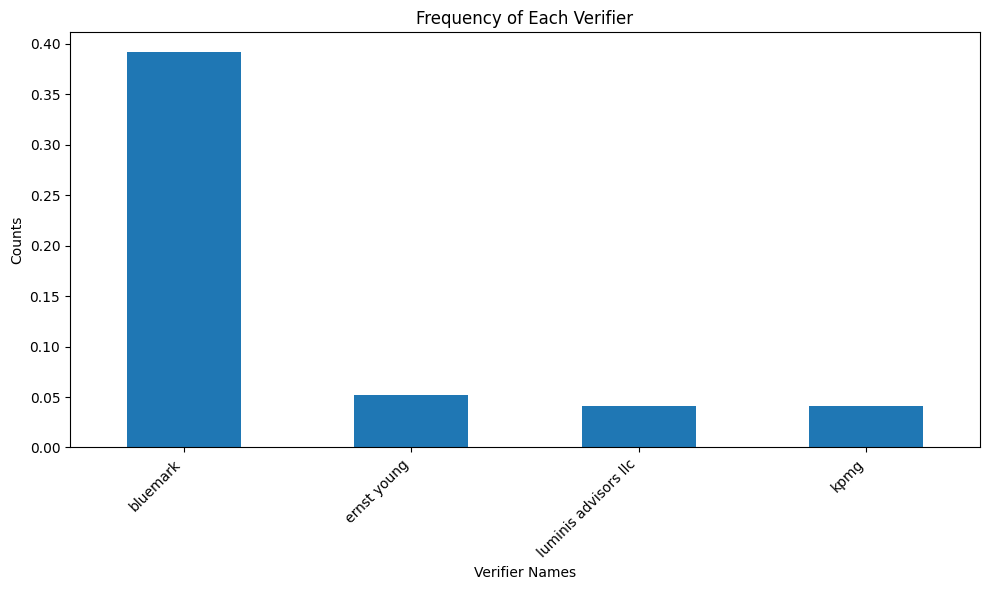

In [78]:
df_ver['Verifier'].value_counts(normalize=True)[:4].plot(kind='bar', figsize=(10, 6))
plt.ylabel('Counts')
plt.xlabel('Verifier Names')
plt.title('Frequency of Each Verifier')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [102]:
# Step 1: Group by 'Verifier' and aggregate names into lists
verifier_names = df_ver.groupby('Verifier')['Name'].agg(list).reset_index()

# Step 2: Explode the 'Name' lists into separate rows, keeping 'Verifier' next to each name
exploded_df = verifier_names.explode('Name')

# Step 3: Create a sort key that orders by the count of names per verifier, then drop the helper column
exploded_df['Count'] = exploded_df.groupby('Verifier')['Verifier'].transform('count')
sorted_df = exploded_df.sort_values(by='Count', ascending=False).drop(columns='Count')

In [101]:
sorted_df[:10]

,Verifier,Name
6,bluemark,FullCycle
6,bluemark,PROPARCO
6,bluemark,Shinsei Impact Investment Limited
6,bluemark,The Private Infrastructure Development Group Ltd.
6,bluemark,U.S. International Development Finance Corpora...
6,bluemark,Big Society Capital
6,bluemark,British International Investment plc
6,bluemark,"Calvert Impact, Inc."
6,bluemark,Clime Capital Management Pte Ltd
6,bluemark,Development Partners International LLP


In [105]:
sorted_df[38:43]

,Verifier,Name
15,ernst young,UOB Venture Management Private Limited
15,ernst young,International Finance Corporation (IFC)
15,ernst young,MEF - Microfinance Enhancement Facility
15,ernst young,Mirova
15,ernst young,Circulate Capital Management Pte Ltd


In [108]:
sorted_df[44:47]

,Verifier,Name
26,kpmg,Octopus Investments
26,kpmg,The Rise Fund
26,kpmg,BMO Financial Group


In [111]:
sorted_df[48:51]

,Verifier,Name
28,luminis advisors llc,"Kiva Capital Management, LLC"
28,luminis advisors llc,MicroVest Capital Management LLC
28,luminis advisors llc,"Capricorn Investment Group, LLC"
